## Supervised models
This notebook is intended for giving an introduction the ML supervised models that can be used for Covid detection.

For this notebook to find the new modules created for this project, we need to set its path to be in the root directory.

In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

<img src="../images/Supervised_Models.png" width="800"/>

## Loading packages and dependencies

In [3]:
from src.preprocessing.image_augmentor import generate_augmented_images
from src.models.build_model import train_advanced_supervised_model, evaluate_model
from src.visualization.visualizer import show_grad_cam_cnn, get_predication_output,show_loss_accuracy_report, show_confusion_matrix_report

# Path to the raw data and preprocessed data
raw_data_dir = '../data/raw/dataset/masked_images'
store_images_dir = '../reports/images/grad_cam'
IMG_SIZE = 256  # Resize images to IMG_SIZExIMG_SIZE pixels
batch_size = 32

## Extracting features from images

In [4]:
train_data, val_data, class_weight_dict = generate_augmented_images(raw_data_dir, (IMG_SIZE, IMG_SIZE), batch_size)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.


2025-04-17 19:42:43.116231: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-04-17 19:42:43.116263: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2025-04-17 19:42:43.116266: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2025-04-17 19:42:43.116282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-17 19:42:43.116291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 21165 files belonging to 4 classes.
Using 4233 files for validation.
Computed Class Weights:{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0} labels: ['COVID', 'Lung_Opacity', 'NORMAL', 'Viral Pneumonia']


## Training and evaluating models

#### Trying 4 convolutional layers

In [5]:
# Train the model
cnn_model_4l, cnn_history_4l = train_advanced_supervised_model(train_data, val_data, IMG_SIZE, 50, 4, class_weight_dict, filter_layers=[32, 64], conv2d_layers=2,dense_layers=[32], attention=True, aspp=True, model_type='CNN', classification_type='categorical')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ resizing[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │         96 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 4,581,226 (17.48 MB)

 Trainable params: 4,580,842 (17.47 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50


2025-04-17 19:42:46.699240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 94s 166ms/step - accuracy: 0.4552 - loss: 4.0895 - val_accuracy: 0.3121 - val_loss: 1.6724 - learning_rate: 1.0000e-04
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 87s 164ms/step - accuracy: 0.5649 - loss: 4.3779 - val_accuracy: 0.7375 - val_loss: 1.7101 - learning_rate: 1.0000e-04
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 93s 175ms/step - accuracy: 0.6048 - loss: 3.7271 - val_accuracy: 0.7475 - val_loss: 2.6819 - learning_rate: 1.0000e-04
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 94s 177ms/step - accuracy: 0.6337 - loss: 3.7903 - val_accuracy: 0.7791 - val_loss: 1.5522 - learning_rate: 1.0000e-04
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 90s 170ms/step - accuracy: 0.6614 - loss: 3.2425 - val_accuracy: 0.7652 - val_loss: 2.0345 - learning_rate: 1.0000e-04
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 93s 175ms/step - accuracy: 0.6742 - loss: 3.5484 - val_accuracy: 0.8034 - val_loss: 1.7238 - learning_rate: 1.0000e-04
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 93s 176ms/step - 

In [6]:
cnn_train_loss_4l, cnn_train_acc_4l = cnn_history_4l.history['loss'][-1], cnn_history_4l.history['accuracy'][-1]
print(f"Train Accuracy: {cnn_train_acc_4l:.4f}, Train Loss: {cnn_train_loss_4l:.4f}")

cnn_test_loss_4l, cnn_test_acc_4l = evaluate_model("Multi-label classification [Normal, COVID, Viral Pneumonia, Lung_Opacity] for masked images", cnn_model_4l, val_data, _, model_type="CNN", classification_type="multiclass", history=cnn_history_4l)
print(f"Test Accuracy: {cnn_test_acc_4l:.4f}, Test Loss: {cnn_test_loss_4l:.4f}")

Train Accuracy: 0.7093, Train Loss: 3.2303
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7747 - loss: 1.5995
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step


2025-04-17 19:56:48.023925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-17 19:56:48.326716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


Registered model 'tensorflow-CNN-multiclass' already exists. Creating a new version of this model...
2025/04/17 19:57:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tensorflow-CNN-multiclass, version 18


🏃 View run CNN-multiclass at: http://localhost:8080/#/experiments/256036775927951482/runs/7822881572a34dd18d3c65288be25f66
🧪 View experiment at: http://localhost:8080/#/experiments/256036775927951482
Test Accuracy: 0.7791, Test Loss: 1.5522


Created version '18' of model 'tensorflow-CNN-multiclass'.


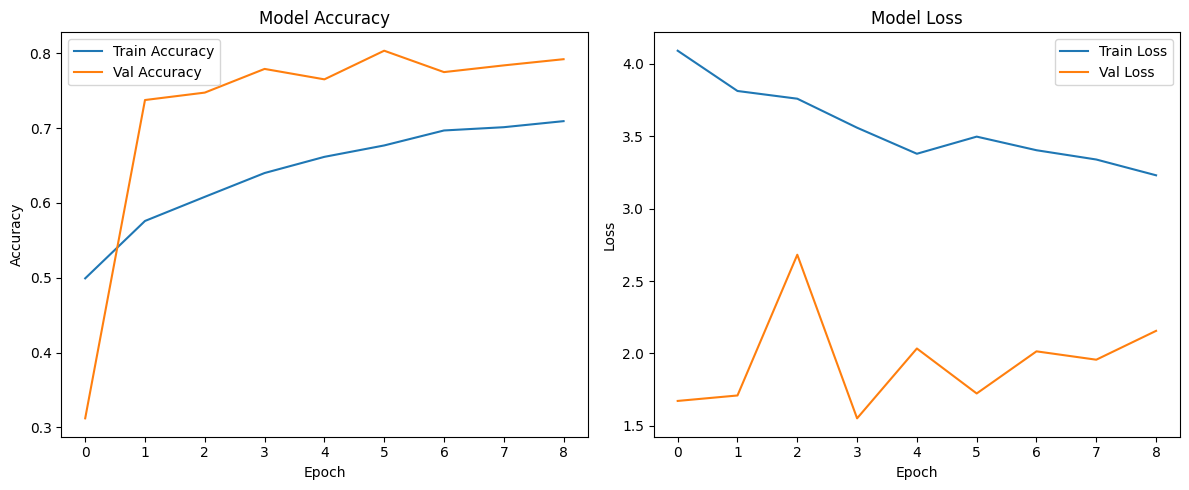

In [7]:
show_loss_accuracy_report(cnn_history_4l)

In [8]:
show_confusion_matrix_report(cnn_model_4l, val_data)

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step
[[  61  212  403   37]
 [ 102  388  608   67]
 [ 182  617 1133  126]
 [  22   81  171   23]]
              precision    recall  f1-score   support

           0       0.17      0.09      0.11       713
           1       0.30      0.33      0.32      1165
           2       0.49      0.55      0.52      2058
           3       0.09      0.08      0.08       297

    accuracy                           0.38      4233
   macro avg       0.26      0.26      0.26      4233
weighted avg       0.35      0.38      0.36      4233



2025-04-17 19:57:07.426985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
val_iter = iter(val_data)
class_names = val_data.class_names
images, labels =next(val_iter)

Model interpretation with GradCam for random validation images is saved to `reports/images/grad_cam`.

In [10]:
show_grad_cam_cnn(images[:4], cnn_model_4l, class_names, labels, save_dir=store_images_dir, image_name="3.9_cnn_4_layers", save_image=True)

Show prediction results for random images.

In [11]:
display(get_predication_output(images[:4], cnn_model_4l, class_names, labels).head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,image,confidence,predicted_class,actual_class
0,0,99.999988,Viral Pneumonia,Viral Pneumonia
1,1,99.999440,Lung_Opacity,Lung_Opacity
2,2,99.999988,NORMAL,NORMAL
3,3,99.996626,NORMAL,NORMAL


#### Trying 8 convolutional layers

In [12]:
cnn_model_8l, cnn_history_8l = train_advanced_supervised_model(train_data, val_data, IMG_SIZE, 50, 4, class_weight_dict, filter_layers=[32, 64, 128, 256], conv2d_layers=2, dense_layers=[128, 32], attention=True, aspp=True, model_type='CNN', classification_type='categorical')

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 128, 128,  │          0 │ rescaling_1[0][0] │
│ (Resizing)          │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │        320 │ resizing_1[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │         96 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 32)  │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 64, 64,    │          0 │ max_pooling2d_2[… │
│ (Multiply)          │ 32)               │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │     18,496 │ multiply_2[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 3,272,834 (12.48 MB)

 Trainable params: 3,270,914 (12.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 144s 258ms/step - accuracy: 0.5674 - loss: 1.2639 - val_accuracy: 0.4989 - val_loss: 1.3171 - learning_rate: 1.0000e-04
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 133s 252ms/step - accuracy: 0.6414 - loss: 2.2176 - val_accuracy: 0.7538 - val_loss: 1.0791 - learning_rate: 1.0000e-04
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 141s 266ms/step - accuracy: 0.6535 - loss: 2.8797 - val_accuracy: 0.7820 - val_loss: 2.1936 - learning_rate: 1.0000e-04
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 141s 266ms/step - accuracy: 0.6747 - loss: 4.5027 - val_accuracy: 0.6787 - val_loss: 5.3542 - learning_rate: 1.0000e-04
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 141s 267ms/step - accuracy: 0.6890 - loss: 6.7626 - val_accuracy: 0.7994 - val_loss: 4.7187 - learning_rate: 1.0000e-04
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 139s 262ms/step - accuracy: 0.7155 - loss: 9.3397 - val_accuracy: 0.6367 - val_loss: 28.4896 - learning_rate: 1.0000e-04
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━

In [13]:
cnn_train_loss_8l, cnn_train_acc_8l = cnn_history_8l.history['loss'][-1], cnn_history_8l.history['accuracy'][-1]
print(f"Train Accuracy: {cnn_train_acc_8l:.4f}, Train Loss: {cnn_train_loss_8l:.4f}")

cnn_test_loss_8l, cnn_test_acc_8l = evaluate_model("Multi-label classification [Normal, COVID, Viral Pneumonia, Lung_Opacity] for masked images", cnn_model_8l, val_data, _, model_type="CNN", classification_type="multiclass", history=cnn_history_8l)
print(f"Test Accuracy: {cnn_test_acc_8l:.4f}, Test Loss: {cnn_test_loss_8l:.4f}")

Train Accuracy: 0.7189, Train Loss: 17.9555
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7558 - loss: 1.0542
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


2025-04-17 20:13:50.377284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-17 20:13:50.576285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


Registered model 'tensorflow-CNN-multiclass' already exists. Creating a new version of this model...
2025/04/17 20:14:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tensorflow-CNN-multiclass, version 19


🏃 View run CNN-multiclass at: http://localhost:8080/#/experiments/256036775927951482/runs/9708a7dd1fc14e4695a8463681308955
🧪 View experiment at: http://localhost:8080/#/experiments/256036775927951482
Test Accuracy: 0.7538, Test Loss: 1.0791


Created version '19' of model 'tensorflow-CNN-multiclass'.


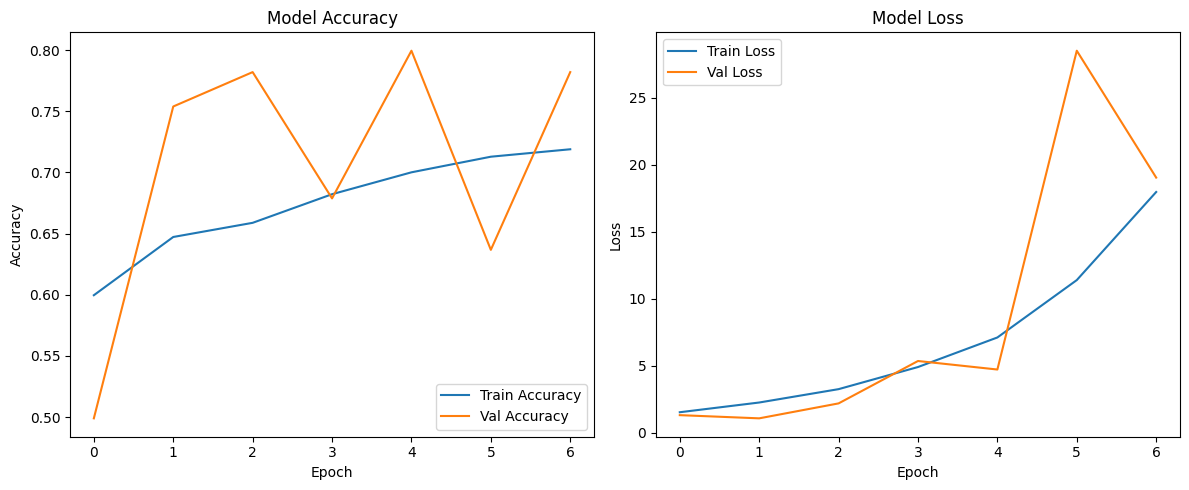

In [14]:
show_loss_accuracy_report(cnn_history_8l)

In [15]:
show_confusion_matrix_report(cnn_model_8l, val_data)

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
[[  84  190  385   54]
 [ 142  287  635  101]
 [ 266  585 1033  174]
 [  43   82  143   29]]
              precision    recall  f1-score   support

           0       0.16      0.12      0.13       713
           1       0.25      0.25      0.25      1165
           2       0.47      0.50      0.49      2058
           3       0.08      0.10      0.09       297

    accuracy                           0.34      4233
   macro avg       0.24      0.24      0.24      4233
weighted avg       0.33      0.34      0.33      4233



2025-04-17 20:14:07.555886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
show_grad_cam_cnn(images[:4], cnn_model_8l, class_names, labels, save_dir=store_images_dir, image_name="3.9_cnn_8_layers", save_image=True)

In [17]:
display(get_predication_output(images[:4], cnn_model_8l, class_names, labels).head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


,image,confidence,predicted_class,actual_class
0,0,100.000000,Viral Pneumonia,Viral Pneumonia
1,1,99.999666,Lung_Opacity,Lung_Opacity
2,2,99.980813,NORMAL,NORMAL
3,3,99.970561,NORMAL,NORMAL


#### Trying 12 convolutional layers

In [18]:
cnn_model_12l, cnn_history_12l = train_advanced_supervised_model(train_data, val_data, IMG_SIZE, 50, 4, class_weight_dict, filter_layers=[32, 64, 128, 256], conv2d_layers=3, dense_layers=[128, 32], attention=True, aspp=True, model_type='CNN', classification_type='categorical')

Model: "functional_98"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_2          │ (None, 128, 128,  │          0 │ rescaling_2[0][0] │
│ (Resizing)          │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │        320 │ resizing_2[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_6[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │         96 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1, 1, 32)  │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 64, 64,    │          0 │ max_pooling2d_6[… │
│ (Multiply)          │ 32)               │            │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │     18,496 │ multiply_6[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat

 Total params: 4,058,594 (15.48 MB)

 Trainable params: 4,055,714 (15.47 MB)

 Non-trainable params: 2,880 (11.25 KB)

Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 128s 228ms/step - accuracy: 0.5044 - loss: 2.3568 - val_accuracy: 0.4774 - val_loss: 1.2382 - learning_rate: 1.0000e-04
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 117s 221ms/step - accuracy: 0.5690 - loss: 7.0976 - val_accuracy: 0.6863 - val_loss: 9.1774 - learning_rate: 1.0000e-04
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 135s 255ms/step - accuracy: 0.6004 - loss: 9.4806 - val_accuracy: 0.5540 - val_loss: 29.4721 - learning_rate: 1.0000e-04
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 151s 285ms/step - accuracy: 0.6052 - loss: 15.9825 - val_accuracy: 0.6981 - val_loss: 16.3823 - learning_rate: 1.0000e-04
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 151s 284ms/step - accuracy: 0.6317 - loss: 20.0615 - val_accuracy: 0.7059 - val_loss: 15.7460 - learning_rate: 1.0000e-04
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6433 - loss: 26.7432
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
530/530 ━━━━━━━━━━━━━━━━━━━━ 

In [19]:
cnn_train_loss_12l, cnn_train_acc_12l = cnn_history_12l.history['loss'][-1], cnn_history_12l.history['accuracy'][-1]
print(f"Train Accuracy: {cnn_train_acc_12l:.4f}, Train Loss: {cnn_train_loss_12l:.4f}")

cnn_test_loss_12l, cnn_test_acc_12l = evaluate_model("Multi-label classification [Normal, COVID, Viral Pneumonia, Lung_Opacity] for masked images", cnn_model_12l, val_data, _, model_type="CNN", classification_type="multiclass", history=cnn_history_12l)
print(f"Test Accuracy: {cnn_test_acc_12l:.4f}, Test Loss: {cnn_test_loss_12l:.4f}")

Train Accuracy: 0.6453, Train Loss: 27.8385
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.4783 - loss: 1.2495
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step


2025-04-17 20:28:24.884712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-17 20:28:25.086840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


Registered model 'tensorflow-CNN-multiclass' already exists. Creating a new version of this model...
2025/04/17 20:28:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tensorflow-CNN-multiclass, version 20


🏃 View run CNN-multiclass at: http://localhost:8080/#/experiments/256036775927951482/runs/ef03df7e741a4870ac649a44e9d815a9
🧪 View experiment at: http://localhost:8080/#/experiments/256036775927951482
Test Accuracy: 0.4774, Test Loss: 1.2382


Created version '20' of model 'tensorflow-CNN-multiclass'.


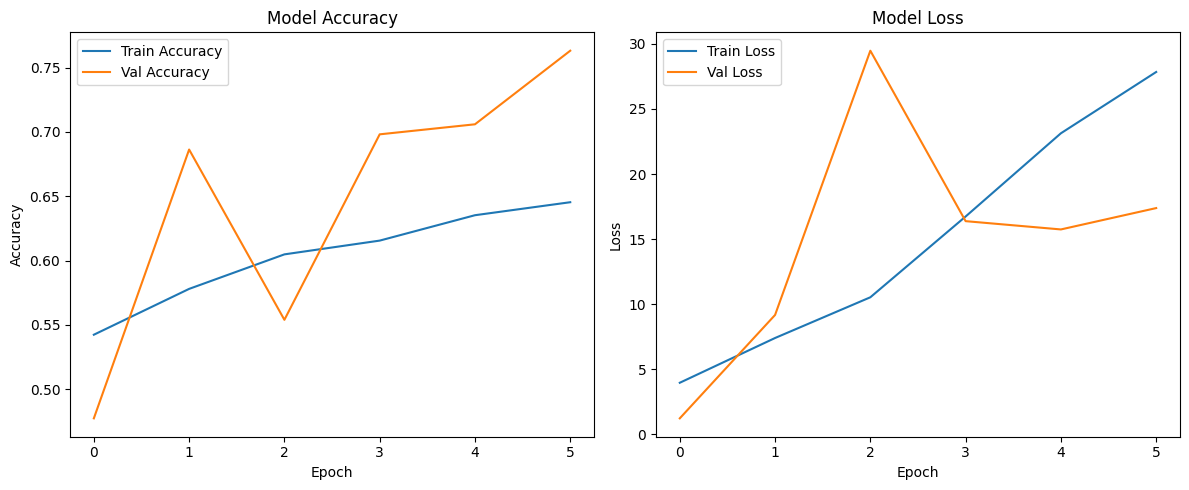

In [20]:
show_loss_accuracy_report(cnn_history_12l)

In [21]:
show_confusion_matrix_report(cnn_model_12l, val_data)

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
[[   1   60  652    0]
 [   0  106 1058    1]
 [   0  201 1856    1]
 [   0   28  269    0]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       713
           1       0.27      0.09      0.14      1165
           2       0.48      0.90      0.63      2058
           3       0.00      0.00      0.00       297

    accuracy                           0.46      4233
   macro avg       0.44      0.25      0.19      4233
weighted avg       0.48      0.46      0.34      4233



2025-04-17 20:28:42.977175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
show_grad_cam_cnn(images[:4], cnn_model_12l, class_names, labels, save_dir=store_images_dir, image_name="3.9_cnn_12_layers", save_image=True)

In [23]:
display(get_predication_output(images[:4], cnn_model_12l, class_names, labels).head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


,image,confidence,predicted_class,actual_class
0,0,99.998093,Lung_Opacity,Viral Pneumonia
1,1,83.812934,Lung_Opacity,Lung_Opacity
2,2,38.991648,NORMAL,NORMAL
3,3,46.527764,NORMAL,NORMAL


#### Trying 16 convolutional layers

In [24]:
cnn_model_16l, cnn_history_16l = train_advanced_supervised_model(train_data, val_data, IMG_SIZE, 50, 4, class_weight_dict, filter_layers=[32, 64, 128, 256], conv2d_layers=4, dense_layers=[128, 32], attention=True, aspp=True, model_type='CNN', classification_type='categorical')

Model: "functional_171"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_3          │ (None, 128, 128,  │          0 │ rescaling_3[0][0] │
│ (Resizing)          │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 128, 128,  │        320 │ resizing_3[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_10… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 32)        │         96 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1, 1, 32)  │          0 │ dense_29[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 64, 64,    │          0 │ max_pooling2d_10… │
│ (Multiply)          │ 32)               │            │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,844,354 (18.48 MB)

 Trainable params: 4,840,514 (18.47 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 141s 249ms/step - accuracy: 0.4727 - loss: 1.9766 - val_accuracy: 0.4862 - val_loss: 6.6538 - learning_rate: 1.0000e-04
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 129s 243ms/step - accuracy: 0.5763 - loss: 9.4543 - val_accuracy: 0.7134 - val_loss: 14.1075 - learning_rate: 1.0000e-04
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 129s 243ms/step - accuracy: 0.5707 - loss: 20.6906 - val_accuracy: 0.5396 - val_loss: 229.3443 - learning_rate: 1.0000e-04
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 131s 247ms/step - accuracy: 0.4715 - loss: 21.4587 - val_accuracy: 0.4318 - val_loss: 109.8776 - learning_rate: 1.0000e-04
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 131s 247ms/step - accuracy: 0.4807 - loss: 42.8859 - val_accuracy: 0.3695 - val_loss: 1.9667 - learning_rate: 1.0000e-04
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 131s 248ms/step - accuracy: 0.4391 - loss: 74.6692 - val_accuracy: 0.4954 - val_loss: 126.8459 - learning_rate: 1.0000e-04
Epoch 7/50
530/530 ━━━━━━━━━━

In [25]:
cnn_train_loss_16l, cnn_train_acc_16l = cnn_history_16l.history['loss'][-1], cnn_history_16l.history['accuracy'][-1]
print(f"Train Accuracy: {cnn_train_acc_16l:.4f}, Train Loss: {cnn_train_loss_16l:.4f}")

cnn_test_loss_16l, cnn_test_acc_16l = evaluate_model("Multi-label classification [Normal, COVID, Viral Pneumonia, Lung_Opacity] for masked images", cnn_model_16l, val_data, _, model_type="CNN", classification_type="multiclass", history=cnn_history_16l)
print(f"Test Accuracy: {cnn_test_acc_16l:.4f}, Test Loss: {cnn_test_loss_16l:.4f}")

Train Accuracy: 0.5834, Train Loss: 4.7045
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.3069 - loss: 1.2961
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step


2025-04-17 20:58:29.787063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/rehabaam/codes/python/datascientest/project/ds_covid19_project/.ds_covid19/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-04-17 20:58:30.080601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step


Registered model 'tensorflow-CNN-multiclass' already exists. Creating a new version of this model...
2025/04/17 20:58:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tensorflow-CNN-multiclass, version 21


🏃 View run CNN-multiclass at: http://localhost:8080/#/experiments/256036775927951482/runs/e5e0d55a66514afda64e299f7535a749
🧪 View experiment at: http://localhost:8080/#/experiments/256036775927951482
Test Accuracy: 0.3189, Test Loss: 1.2970


Created version '21' of model 'tensorflow-CNN-multiclass'.


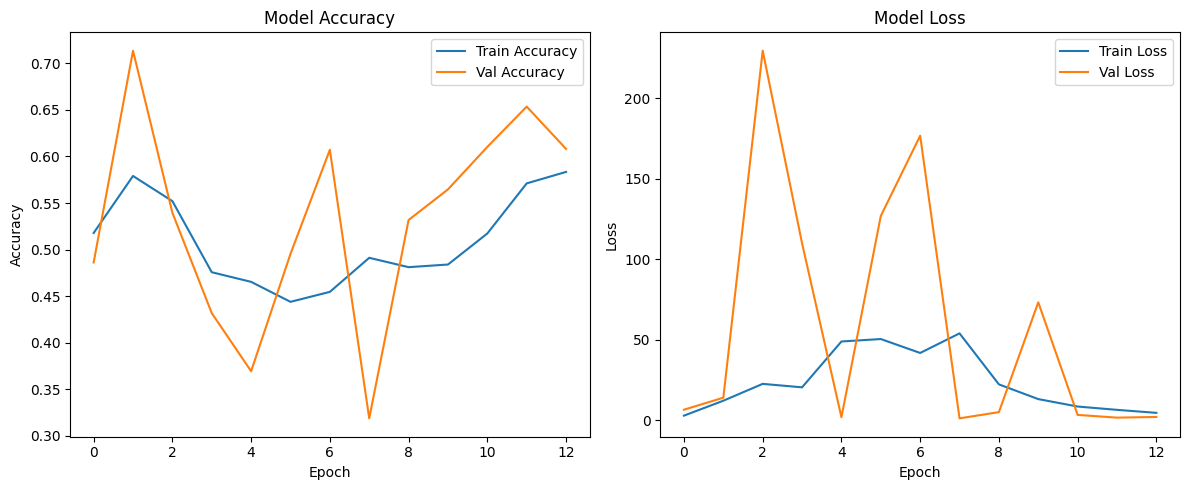

In [26]:
show_loss_accuracy_report(cnn_history_16l)

In [27]:
show_confusion_matrix_report(cnn_model_16l, val_data)

133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step
[[   0  683   30    0]
 [   0 1110   55    0]
 [   0 1956  102    0]
 [   0  285   12    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       713
           1       0.28      0.95      0.43      1165
           2       0.51      0.05      0.09      2058
           3       0.00      0.00      0.00       297

    accuracy                           0.29      4233
   macro avg       0.20      0.25      0.13      4233
weighted avg       0.32      0.29      0.16      4233



2025-04-17 20:58:50.937562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/rehabaam/codes/python/datascientest/project/ds_covid19_project/.ds_covid19/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rehabaam/codes/python/datascientest/project/ds_covid19_project/.ds_covid19/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rehabaam/codes/python/datascientest/project/ds_covid19_project/.

In [28]:
show_grad_cam_cnn(images[:4], cnn_model_16l, class_names, labels, save_dir=store_images_dir, image_name="3.9_cnn_16_layers", save_image=True)

In [29]:
display(get_predication_output(images[:4], cnn_model_16l, class_names, labels).head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


,image,confidence,predicted_class,actual_class
0,0,35.915977,Lung_Opacity,Viral Pneumonia
1,1,98.416466,Lung_Opacity,Lung_Opacity
2,2,100.000000,NORMAL,NORMAL
3,3,100.000000,NORMAL,NORMAL


### 20 convoluational layers

In [30]:
cnn_model_20l, cnn_history_20l = train_advanced_supervised_model(train_data, val_data, IMG_SIZE, 50, 4, class_weight_dict, filter_layers=[32, 64, 128, 256, 512], conv2d_layers=4, dense_layers=[256, 128, 64, 32], attention=True, aspp=True, model_type='CNN', classification_type='categorical')

Model: "functional_260"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 256, 256,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_4          │ (None, 128, 128,  │          0 │ rescaling_4[0][0] │
│ (Resizing)          │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 128, 128,  │        320 │ resizing_4[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_14… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 32)        │         96 │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_18          │ (None, 1, 1, 32)  │          0 │ dense_40[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_14         │ (None, 64, 64,    │          0 │ max_pooling2d_14… │
│ (Multiply)          │ 32)               │            │ reshape_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,610,658 (51.92 MB)

 Trainable params: 13,602,722 (51.89 MB)

 Non-trainable params: 7,936 (31.00 KB)

Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 191s 336ms/step - accuracy: 0.4314 - loss: 3.4055 - val_accuracy: 0.5511 - val_loss: 1.1696 - learning_rate: 1.0000e-04
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 200s 378ms/step - accuracy: 0.5041 - loss: 7.9926 - val_accuracy: 0.6126 - val_loss: 4.2188 - learning_rate: 1.0000e-04
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 211s 398ms/step - accuracy: 0.4888 - loss: 15.3534 - val_accuracy: 0.5015 - val_loss: 10.2418 - learning_rate: 1.0000e-04
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 216s 407ms/step - accuracy: 0.4964 - loss: 30.4309 - val_accuracy: 0.2752 - val_loss: 6421.9141 - learning_rate: 1.0000e-04
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 219s 413ms/step - accuracy: 0.4102 - loss: 48.9941 - val_accuracy: 0.5493 - val_loss: 4.3323 - learning_rate: 1.0000e-04
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.4378 - loss: 102.9728
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
530/530 ━━━━━━━━━━━━━━━━━━

In [31]:
cnn_train_loss_20l, cnn_train_acc_20l = cnn_history_20l.history['loss'][-1], cnn_history_20l.history['accuracy'][-1]
print(f"Train Accuracy: {cnn_train_acc_20l:.4f}, Train Loss: {cnn_train_loss_20l:.4f}")

cnn_test_loss_20l, cnn_test_acc_20l = evaluate_model("Multi-label classification [Normal, COVID, Viral Pneumonia, Lung_Opacity] for masked images", cnn_model_20l, val_data, _, model_type="CNN", classification_type="multiclass", history=cnn_history_20l)
print(f"Test Accuracy: {cnn_test_acc_20l:.4f}, Test Loss: {cnn_test_loss_20l:.4f}")

Train Accuracy: 0.4400, Train Loss: 101.1489
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.5562 - loss: 1.1605
133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step


2025-04-17 21:20:40.395467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/rehabaam/codes/python/datascientest/project/ds_covid19_project/.ds_covid19/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-04-17 21:20:40.969530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step


Registered model 'tensorflow-CNN-multiclass' already exists. Creating a new version of this model...
2025/04/17 21:21:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tensorflow-CNN-multiclass, version 22


🏃 View run CNN-multiclass at: http://localhost:8080/#/experiments/256036775927951482/runs/77be23405f99418fae2fe0b7a2ff499e
🧪 View experiment at: http://localhost:8080/#/experiments/256036775927951482
Test Accuracy: 0.5511, Test Loss: 1.1696


Created version '22' of model 'tensorflow-CNN-multiclass'.


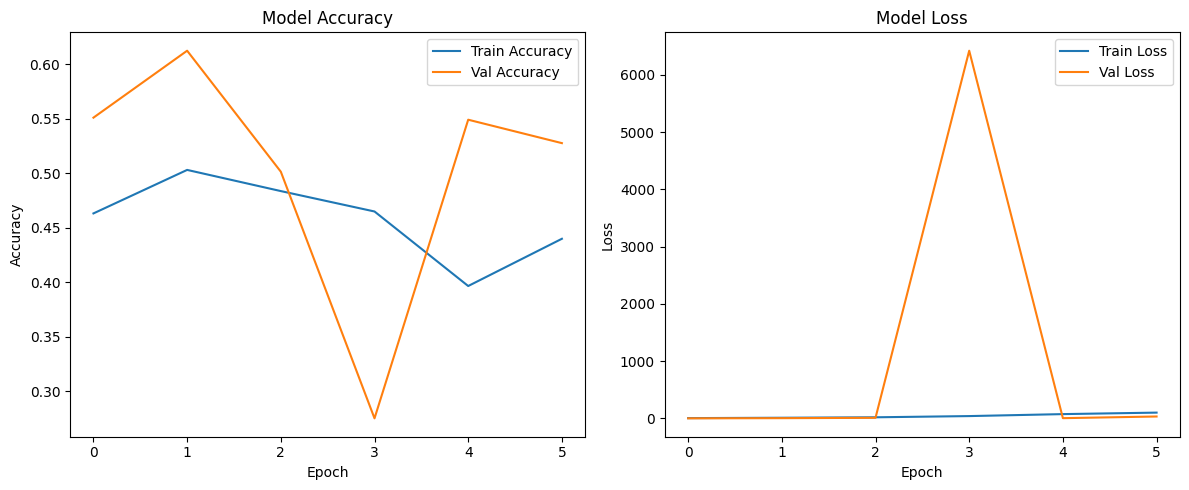

In [32]:
show_loss_accuracy_report(cnn_history_20l)

In [33]:
show_confusion_matrix_report(cnn_model_20l, val_data)

133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step
[[   0  188  525    0]
 [   0  298  867    0]
 [   0  500 1558    0]
 [   0   77  220    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       713
           1       0.28      0.26      0.27      1165
           2       0.49      0.76      0.60      2058
           3       0.00      0.00      0.00       297

    accuracy                           0.44      4233
   macro avg       0.19      0.25      0.22      4233
weighted avg       0.32      0.44      0.36      4233



2025-04-17 21:21:20.465492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/rehabaam/codes/python/datascientest/project/ds_covid19_project/.ds_covid19/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rehabaam/codes/python/datascientest/project/ds_covid19_project/.ds_covid19/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rehabaam/codes/python/datascientest/project/ds_covid19_project/.

In [34]:
show_grad_cam_cnn(images[:4], cnn_model_20l, class_names, labels, save_dir=store_images_dir, image_name="3.9_cnn_20_layers", save_image=True)

In [35]:
display(get_predication_output(images[:4], cnn_model_20l, class_names, labels).head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


,image,confidence,predicted_class,actual_class
0,0,51.346189,NORMAL,Viral Pneumonia
1,1,100.000000,Lung_Opacity,Lung_Opacity
2,2,69.366580,NORMAL,NORMAL
3,3,50.532436,NORMAL,NORMAL
